# Thêm thư viện cần thiết


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 4.9 MB/s 
     |████████████████████████████████| 9.8 MB 1.9 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
import pandas as pd
import warnings
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from sklearn.preprocessing import StandardScaler
from sklearn.utils import column_or_1d
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

warnings.filterwarnings('ignore')


# Nạp dữ liệu


In [ ]:
train_BTC = pd.read_csv("/content/drive/My Drive/Năm 3/Làm nhóm HK2 2021 - 2022/Cá nhân/More/SF/Dataset/Data/9_1/btc/bitcoin_train_9_1.csv", parse_dates=True, index_col=0)
train_BTC.head(5)

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2020-06-01,9.4545,10.3018,9.4297,10.1893,796676,USD
2020-06-02,10.1907,10.2073,9.3473,9.5276,1058556,USD
2020-06-03,9.5270,9.6672,9.4217,9.6672,558116,USD
2020-06-04,9.6672,9.8644,9.4909,9.7944,593664,USD
2020-06-05,9.7940,9.8461,9.6287,9.6312,527054,USD


In [ ]:
train = train_BTC[["Open"]]
train.head(5)

,Open
Date,
2020-06-01,9.4545
2020-06-02,10.1907
2020-06-03,9.5270
2020-06-04,9.6672
2020-06-05,9.7940


In [ ]:
test_BTC = pd.read_csv("/content/drive/My Drive/Năm 3/Làm nhóm HK2 2021 - 2022/Cá nhân/More/SF/Dataset/Data/9_1/btc/bitcoin_test_9_1.csv", parse_dates=True, index_col=0)
test_BTC.head(5)

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2022-03-21,41.282,41.5320,40.530,41.022,406616256,USD
2022-03-22,41.022,43.3279,40.893,42.373,537056064,USD
2022-03-23,42.373,43.0270,41.795,42.912,433957536,USD
2022-03-24,42.911,44.2510,42.658,44.013,491663072,USD
2022-03-25,44.013,45.1120,43.622,44.331,494089824,USD


In [ ]:
test = test_BTC[["Open"]]
test.head(5)

,Open
Date,
2022-03-21,41.282
2022-03-22,41.022
2022-03-23,42.373
2022-03-24,42.911
2022-03-25,44.013


In [ ]:
df = pd.concat([train.reset_index(level=0), test.reset_index(level=0)],    # Combine vertically
                          ignore_index = True,
                          sort = False)
df.index=df.Date
df.drop("Date", axis=1, inplace=True)
df.head(5)    

,Open
Date,
2020-06-01,9.4545
2020-06-02,10.1907
2020-06-03,9.5270
2020-06-04,9.6672
2020-06-05,9.7940


# Vẽ đồ thị

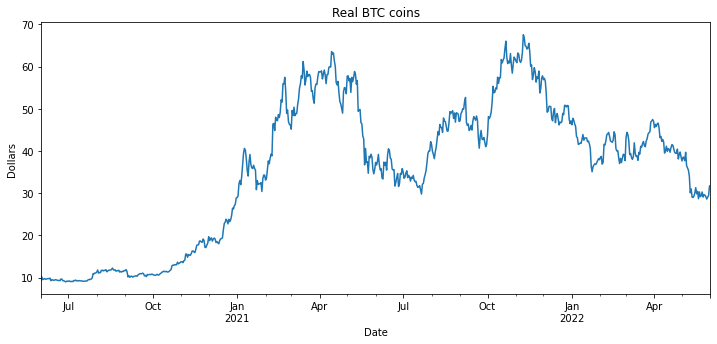

In [ ]:
# Thư viện vẽ đồ thị
import matplotlib.ticker as ticker
formatter = ticker.StrMethodFormatter('{x:,.0f}')

title = 'Real BTC coins'
ylabel='Dollars'
xlabel='Date' 

ax = df['Open'].plot(figsize=(12,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

# Kiểm tra tính dừng của chuỗi

In [ ]:
def adf_test(series, title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    # .dropna() handles differenced data
    result = adfuller(series.dropna(), autolag='AIC')

    labels = ['ADF test statistic', 'p-value',
              'Number of lags used', 'Number of observations']
    out = pd.Series(result[0:4], index=labels)

    for key, val in result[4].items():
        out[f'critical value ({key})'] = val

    # .to_string() removes the line "dtype: float64"
    print(out.to_string())

    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non stationary")


In [ ]:
adf_test(df['Open'], 'Bitcoin Price')


Augmented Dickey-Fuller Test: Bitcoin Price
ADF test statistic         -1.711262
p-value                     0.425319
Number of lags used         0.000000
Number of observations    730.000000
critical value (1%)        -3.439340
critical value (5%)        -2.865507
critical value (10%)       -2.568883
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non stationary


##### Nhận thấy p-value > 0.05, do đó chuỗi không phải là chuỗi dừng


# Lấy sai phân bậc 1 (d = 1) của chuỗi để kiểm định tính dừng


In [ ]:
df['diff1'] = df['Open'].diff()
df.head()


,Open,diff1
Date,,
2020-06-01,9.4545,NaN
2020-06-02,10.1907,0.7362
2020-06-03,9.5270,-0.6637
2020-06-04,9.6672,0.1402
2020-06-05,9.7940,0.1268


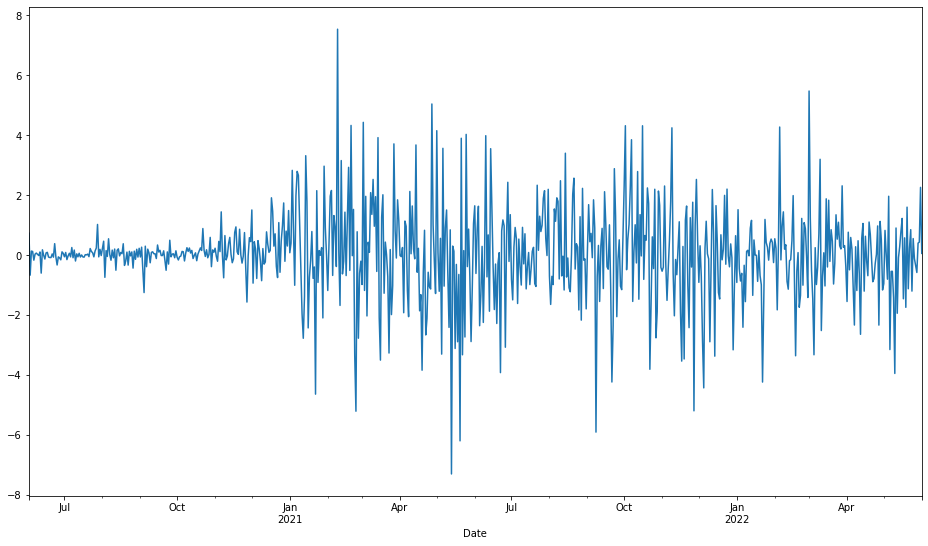

In [ ]:
df['diff1'].dropna().plot(figsize=(16, 9))


# Kiểm định tính dừng của chuỗi tại sai phân bậc 1


In [ ]:
adf_test(df['diff1'], 'Bitcoin Price at First Difference')


Augmented Dickey-Fuller Test: Bitcoin Price at First Difference
ADF test statistic        -28.115359
p-value                     0.000000
Number of lags used         0.000000
Number of observations    729.000000
critical value (1%)        -3.439352
critical value (5%)        -2.865513
critical value (10%)       -2.568886
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


##### Nhận thấy p-value < 0.05, do đó chuỗi có tính dừng tại sai phân bậc 1


# Thực hiện xây dựng mô hình ARIMA

## Cần chuẩn hóa dữ liệu để thuận tiện cho việc xây dựng mô hình

In [ ]:
df_scaled = df.copy().drop(columns=['diff1'])

scaler = StandardScaler()

df_scaled['Open'] = scaler.fit_transform(df_scaled['Open'].values.reshape(-1, 1))
df_scaled.head()

,Open
Date,
2020-06-01,-1.566754
2020-06-02,-1.522736
2020-06-03,-1.562419
2020-06-04,-1.554036
2020-06-05,-1.546455


## Chia dữ liệu thành tập train và tập test

In [ ]:
interrupt = len(train)
interrupt

658

In [ ]:
index_test = df_scaled.index[interrupt:]
print(train.shape)
print(test.shape)
print(index_test.shape)

(658, 1)
(73, 1)
(73,)


In [ ]:
train.tail()

,Open
Date,
2022-03-16,39.2825
2022-03-17,41.1187
2022-03-18,40.9146
2022-03-19,41.7680
2022-03-20,42.2410


In [ ]:
test.head()

,Open
Date,
2022-03-21,41.282
2022-03-22,41.022
2022-03-23,42.373
2022-03-24,42.911
2022-03-25,44.013


## Tìm các hệ số p, q và d phù hợp cho mô hình ARIMA

In [ ]:
warnings.filterwarnings('ignore')


def arima_model(ts_data):
    fit_model = auto_arima(ts_data, test='adf', seasonal=False, trace=True)
    print(fit_model.summary())
    return fit_model


#### Dựa vào chỉ số AIC
- Chỉ số AIC càng thấp thì mô hình càng phù hợp

In [ ]:
fitted = arima_model(train)
fitted.summary()


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.71 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2433.831, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2435.020, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2434.998, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2432.523, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2436.961, Time=0.61 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.610 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  658
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1215.262
Date:                Sun, 26 Jun 2022   AIC                           2432.523
Time:                        02:17:20   BIC                           2437.011
Sample:                             0   HQIC                          2434.263
               

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  658
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1215.262
Date:                Sun, 26 Jun 2022   AIC                           2432.523
Time:                        02:17:20   BIC                           2437.011
Sample:                             0   HQIC                          2434.263
                                - 658                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         2.3668      0.080     29.425      0.000       2.209       2.524
===================================================================================
Ljung-Box (L1) (Q):                   0.82   Jarque-Bera (JB):               298.67
Prob(Q):                              0.37   Prob(JB):                         0.00
Heteroskedasticity (H):              11.30   Skew:                            -0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Dự đoán trên tập test


In [ ]:
pred = fitted.predict(len(test))
pred


array([42.241, 42.241, 42.241, 42.241, 42.241, 42.241, 42.241, 42.241,
       42.241, 42.241, 42.241, 42.241, 42.241, 42.241, 42.241, 42.241,
       42.241, 42.241, 42.241, 42.241, 42.241, 42.241, 42.241, 42.241,
       42.241, 42.241, 42.241, 42.241, 42.241, 42.241, 42.241, 42.241,
       42.241, 42.241, 42.241, 42.241, 42.241, 42.241, 42.241, 42.241,
       42.241, 42.241, 42.241, 42.241, 42.241, 42.241, 42.241, 42.241,
       42.241, 42.241, 42.241, 42.241, 42.241, 42.241, 42.241, 42.241,
       42.241, 42.241, 42.241, 42.241, 42.241, 42.241, 42.241, 42.241,
       42.241, 42.241, 42.241, 42.241, 42.241, 42.241, 42.241, 42.241,
       42.241])

# Vẽ đồ thị cho tập test và kết quả dự đoán

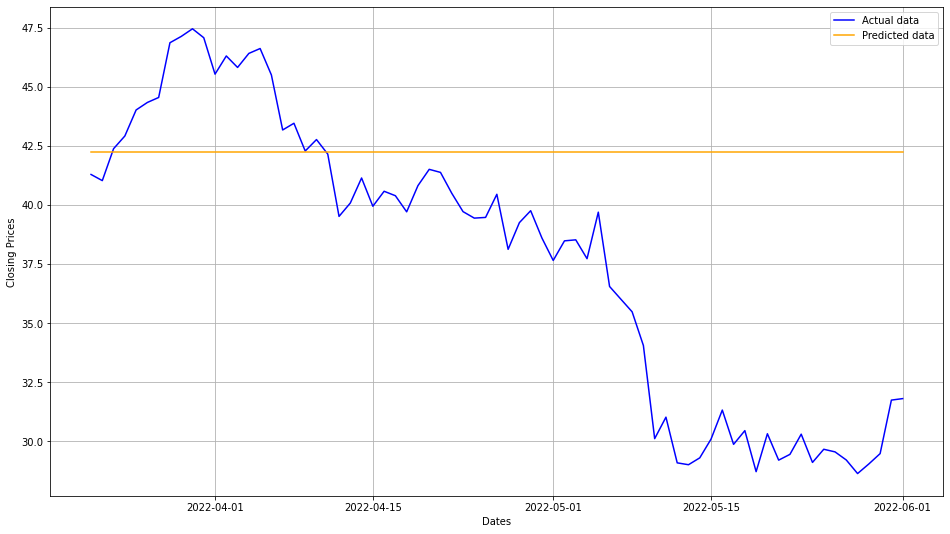

In [ ]:
pred_series = pd.Series(pred, index=index_test)

plt.figure(figsize=(16, 9))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(test, 'blue', label='Actual data')
plt.plot(pred_series, 'orange', label='Predicted data')
plt.legend()


# Đưa dữ liệu về miền giá trị ban đầu


In [ ]:
actual = column_or_1d(test)
pred = column_or_1d(pred)

inv_actual = scaler.inverse_transform(actual.reshape(-1, 1))
inv_pred = scaler.inverse_transform(pred.reshape(-1, 1))


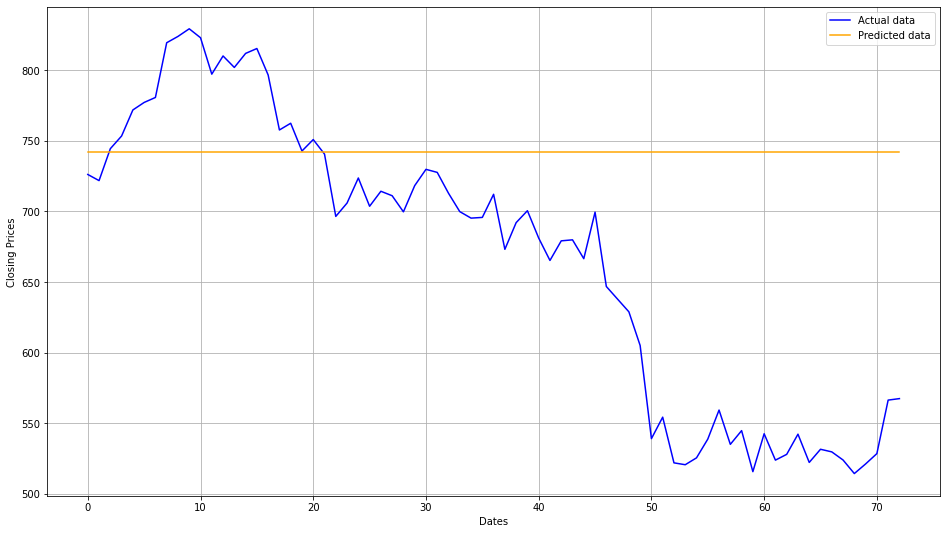

In [ ]:
plt.figure(figsize=(16, 9))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(inv_actual, 'blue', label='Actual data')
plt.plot(inv_pred, 'orange', label='Predicted data')
plt.legend()


# Đánh giá mô hình qua các chỉ số MAE, MAPE, MSE, RMSE

In [ ]:
# mae = mean_absolute_error(inv_actual, inv_pred)
mape = mean_absolute_percentage_error(inv_actual, inv_pred)
mse = mean_squared_error(inv_actual, inv_pred)
rmse = np.sqrt(mse)
r2 = r2_score(inv_actual, inv_pred)

# print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape*100:.2f}%")
# print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")


MAPE: 16.83%
RMSE: 125.80
R2: -0.54
